In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Install xlrd package
%pip install xlrd

all_df = pd.read_excel('TrainDataset2024.xls', index_col=False)
all_df.drop('ID', axis=1, inplace=True)
all_df.head()


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


,pCR (outcome),RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,1,144.0,41.0,0,0,0,1,3,3,1,...,0.517172,0.375126,3.325332,0.002314,3880771.500,473.464852,0.000768,0.182615,0.030508,0.000758
1,0,142.0,39.0,1,1,0,0,3,3,1,...,0.444391,0.444391,3.032144,0.005612,2372009.744,59.459710,0.004383,0.032012,0.001006,0.003685
2,1,135.0,31.0,0,0,0,1,2,1,1,...,0.534549,0.534549,2.485848,0.006752,1540027.421,33.935384,0.007584,0.024062,0.000529,0.006447
3,0,12.0,35.0,0,0,0,1,3,3,1,...,0.506185,0.506185,2.606255,0.003755,6936740.794,46.859265,0.005424,0.013707,0.000178,0.004543
4,0,109.0,61.0,1,0,0,0,2,1,1,...,0.462282,0.462282,2.809279,0.006521,1265399.054,39.621023,0.006585,0.034148,0.001083,0.005626


### Data Imputer

In [2]:
from sklearn.impute import SimpleImputer

# Replace missing values with median of the column
imputer = SimpleImputer(strategy="median", missing_values=999)
all_df[:] = imputer.fit_transform(all_df)

# classification target
clf_y = all_df['pCR (outcome)']
# regression target
rgr_y = all_df['RelapseFreeSurvival (outcome)']

### Outlier Removal

In [3]:
from outlier_removal import removeOutliers

# See the outlier_removal.py file for the implementation of the function
# Remove outliers, assign modified features to X and drop the outcome columns
removeOutliers(all_df)
X = all_df.drop(['pCR (outcome)', 'RelapseFreeSurvival (outcome)'], axis=1)

### Data Normalisation/Standardisation

In [4]:
from sklearn.preprocessing import StandardScaler

# Standardise features by removing the mean and scaling to unit variance.
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

### Feature Selection and Dimensionality Reduction

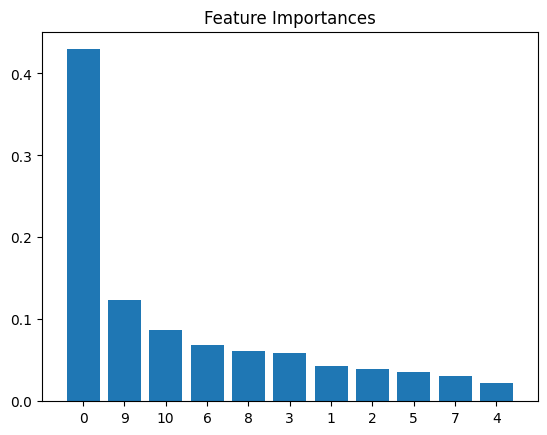

Selected Features: [0, 1, 3, 6, 9, 10]


In [5]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

### Feature Selection and Dimensionality Reduction strategy:
#
# 1. Select the mandatory features ER, HER2 and Gene
# 2. Select the MRI features and apply LDA to them
# 3. Select the top 3 features of the remaining features using Random Forest

# Select the mandatory features
mandatory_features = ['ER', 'HER2', 'Gene']
mandatory_features_indices = [1,3,10]
features_required = Xs[:, mandatory_features_indices]

### Dimensionality Reduction

# Select the MRI features
mri_indices = list(range(11, Xs.shape[1]))
mri = Xs[:, mri_indices]

# Apply LDA to MRI features
lda = LinearDiscriminantAnalysis(n_components=1)
Xs_lda = lda.fit_transform(mri, clf_y)

### Feature Selection

# Remove the MRI features from the feature set
non_mri_features = np.delete(Xs, mri_indices, axis=1)

# Feature selection using Random Forest
rnd_clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
rnd_clf.fit(non_mri_features, clf_y)

# Get the feature importances
importances = rnd_clf.feature_importances_
# Get the indices of the features sorted by importance
selected_indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.title('Feature Importances')
plt.bar(range(non_mri_features.shape[1]), importances[selected_indices], align='center')
plt.xticks(range(non_mri_features.shape[1]), selected_indices)
plt.xlim([-1, non_mri_features.shape[1]])
plt.show()

# Select the top 3 features that are not mandatory features [ER, HER2, Gene]
top_features_indices = [i for i in selected_indices if i not in mandatory_features_indices][:3]
top_features = non_mri_features[:, top_features_indices]

# Combine selected features and LDA transformed feature
Xs = np.hstack((features_required, top_features, Xs_lda))

selected_features_indices = sorted(mandatory_features_indices + [int(i) for i in top_features_indices])
print('Selected Features:', selected_features_indices)


### Split dataset

In [6]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Xs, clf_y, test_size=0.2, random_state=1, stratify=clf_y)

### SVM for Classification

In [7]:
from numpy._core.fromnumeric import mean
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from numpy import std

# this nested cross-validation is used to tune the hyperparameters of the model
# the code was adapted from: 
# Brownlee, J. (2018). Nested Cross-Validation for Machine Learning with Python. [online] Machine Learning Mastery.
# Available at: https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/ [Accessed 5 Dec. 2024]

# configure the cross-validation procedure for the inner loop
cv_inner = KFold(n_splits=5, shuffle=True, random_state=2)

# define the classifier
classifier = SVC(random_state=2)

# define search space of hyperparameters
space = dict()
space['C'] = [0.1, 1, 10]
space['gamma'] = [0.01, 0.1]
space['kernel'] = ["rbf", "linear", "poly"]

# define GridSearch to search for the best hyperparameters
search = GridSearchCV(classifier, space, scoring='accuracy', n_jobs=1, cv=cv_inner, refit=True)

# configure the cross-validation procedure for the outer loop
cv_outer = KFold(n_splits=5, shuffle=True, random_state=2)

# execute the nested cross-validation
scores = cross_val_score(search, X_train, y_train, scoring='accuracy', cv=cv_outer, n_jobs=-1)

# fit the search on the whole dataset to get the best model
search.fit(X_train, y_train)
model = search.best_estimator_

# report performance and best model configuration
print('Nested CV training Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
print('Best Model:', model)

Nested CV training Accuracy: 0.869 (0.032)
Best Model: SVC(C=10, gamma=0.01, kernel='linear', random_state=2)


### Testing model

In [8]:
from sklearn.metrics import classification_report

# Predict using the test set
y_pred = model.predict(X_test)
# Print f1-score, precision, recall and support for prediction using the test set
print(classification_report(y_test, y_pred))
print('Test Accuracy: %.3f' % model.score(X_test, y_test))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94        63
           1       0.81      0.76      0.79        17

    accuracy                           0.91        80
   macro avg       0.88      0.86      0.87        80
weighted avg       0.91      0.91      0.91        80

Test Accuracy: 0.912


### Saving the model

In [9]:
import joblib

joblib.dump({"model": model, "scaler": scaler, "lda": lda, "selected_features_indices": selected_features_indices}, 'pcr_classification_model.joblib')

['pcr_classification_model.joblib']